### **Load all the Required Libraries**

In [3]:
import tensorflow as tf
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, Flatten, Convolution2D, MaxPooling2D,ZeroPadding2D
from tensorflow.keras.layers import Input, Lambda
import matplotlib.pyplot as plt
import numpy as np
import random
import os
from matplotlib import gridspec

### **Load MNIST data and Normalize the data**

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
X_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

11493376/11490434 [==============================] - 0s 0us/step


## **Plotting Some Examples**

In [23]:
def plot(data):
    plt.figure(figsize=(6,2))
    for i in range(0,3):
        plt.subplot(1,3,i+1)
        plt.imshow(data[i].reshape((28,28)), cmap='binary')
    plt.show()

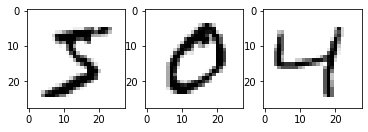

In [24]:
plot([X_train[0],X_train[1],X_train[2],X_train[3],X_train[4]])

## **Creating Triplet Batches**

In [18]:
def create_batch(batch_size,test=False):
    anchors = np.zeros((batch_size,28,28,1))
    positives = np.zeros((batch_size,28,28,1))
    negatives = np.zeros((batch_size,28,28,1))
    if test:
        X = X_test
        y = y_test
    else:
        X = X_train
        y = y_train
        
    for i in range(batch_size):
        index = np.random.randint(len(y))
        anc = X[index]
        label = y[index]

        indcies_for_pos = np.squeeze(np.where(y ==label))
        indcies_for_neg = np.squeeze(np.where(y !=label))
        pos = X[indcies_for_pos[np.random.randint(len(indcies_for_pos))]]
        neg = X[indcies_for_neg[np.random.randint(len(indcies_for_pos))]]
        anchors[i] = anc
        positives[i] = pos
        negatives[i] = neg
        
    return [anchors,positives,negatives]

## **Plotting Triplet**

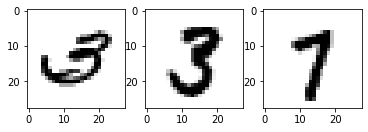

In [25]:
triplets = create_batch(1)
plot(triplets)

## Embedding Model

In [26]:
emb_dim = 512
model = Sequential()
model.add(Convolution2D(32, (3, 3), activation='relu',
                    input_shape=(28,28,1)))
model.add(Convolution2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(emb_dim))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               2359808   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0

### **Siamese Network**

In [31]:
in_anc = Input(shape=(28,28,1))
in_pos = Input(shape=(28,28,1))
in_neg = Input(shape=(28,28,1))

embed_anc = model(in_anc)
embed_pos = model(in_pos)
embed_neg = model(in_neg)

out = tf.keras.layers.concatenate([embed_anc, embed_pos, embed_neg], axis =1)
net = Model([in_anc,in_pos,in_neg], out)
net.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 512)          2632032     input_1[0][0]                    
                                                                 input_2[0][0]         

### **Triplet loss function** 

In [27]:
## Triplet loss
alpha = 0.2
def triplet_loss(y_true,y_pred):
    anc = y_pred[:, :emb_dim]
    pos = y_pred[:,emb_dim:2*emb_dim]
    neg = y_pred[:,2*emb_dim:]
    dp = tf.sqrt(tf.reduce_sum(tf.square(anc-pos), axis=1))
    dn = tf.sqrt(tf.reduce_sum(tf.square(anc-neg), axis=1))
    L = tf.maximum(dp-dn+alpha, 0)
    
    return tf.reduce_mean(L,0)

### **Generating Triplets based on the type data**

In [28]:
def data_gen(batch_size, emb_dim,test=False):
    while True:
        if test:
            x = create_batch(batch_size,test=True)
        else:
            x = create_batch(batch_size)
        y = np.zeros((batch_size, 3*emb_dim))
        yield x,y

## **Defining the hyperparameters for the network and implementing our custom triplet loss function**

In [32]:
batch_size = 1024
epochs = 30
steps_per_epochs = 60000/batch_size
net.compile(loss=triplet_loss,optimizer='adam')
train_gen = data_gen(batch_size,emb_dim)
test_gen = data_gen(batch_size,emb_dim,test=True)

### **Training the model**

In [33]:
history = net.fit_generator(
    train_gen,
    validation_data= test_gen,
    epochs=epochs, steps_per_epoch=steps_per_epochs,
    verbose=1,
    validation_steps=10000/batch_size
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
59/58 [==============================] - 27s 451ms/step - loss: 0.0457 - val_loss: 0.0080
Epoch 2/30
59/58 [==============================] - 27s 450ms/step - loss: 0.0114 - val_loss: 0.0040
Epoch 3/30
59/58 [==============================] - 27s 454ms/step - loss: 0.0079 - val_loss: 0.0031
Epoch 4/30
59/58 [==============================] - 27s 453ms/step - loss: 0.0062 - val_loss: 0.0028
Epoch 5/30
59/58 [==============================] - 27s 453ms/step - loss: 0.0058 - val_loss: 0.0023
Epoch 6/30
59/58 [==============================] - 27s 456ms/step - loss: 0.0047 - val_loss: 0.0023
Epoch 7/30
59/58 [==============================] - 27s 456ms/step - loss: 0.0044 - val_loss: 0.0019
Epoch 8/30
59/58 [==============================] - 27s 455ms/step - loss: 0.0043 - val_loss: 0.0019
Epoch 9/30
59/58 [==============================] - 27s 453ms/step - loss: 0.0039 - val_loss: 0.0022
Epoch 10/30
59/

In [35]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


## Saving the weights of the model

In [36]:
net.save(r'/content/drive/My Drive/saved_models_nrml/trip_cus1_30.h5')

## Plot for trianing anf validation loss

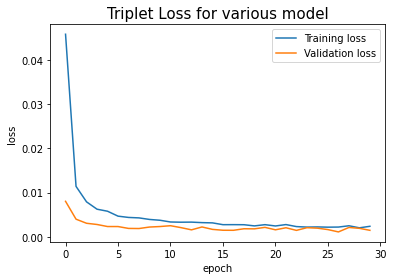

In [38]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Triplet Loss for various model',size = 15)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training loss',
            'Validation loss',],loc='upper right')
plt.show()

In [39]:
a =net.load_weights(r'/content/drive/My Drive/saved_models_nrml/trip_cus1_30.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               2359808   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0

## Loading the .npy file with perturbated image arrays

In [40]:
test_img = np.load(r'/content/drive/My Drive/saved_models_nrml/base_fgsm.npy')
test_img.shape

(10, 28, 28, 1)

## Predicting the perturbated images

In [46]:
search_emb = model.predict(test_img)
search_emb.shape

(10, 512)

## Scatter Plot for original data

In [42]:
from sklearn.manifold import TSNE
universe_emb= model.predict(X_train)
tsne = TSNE()
train_tsne_embeds = tsne.fit_transform(universe_emb)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


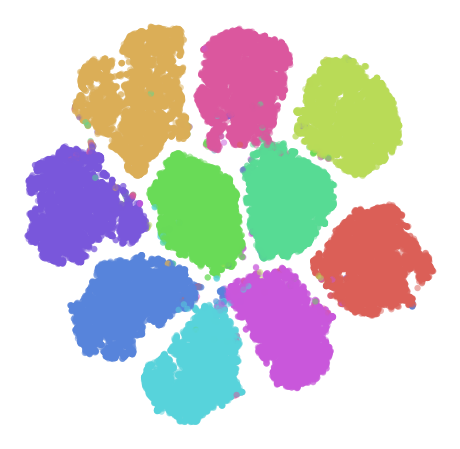

In [43]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import pandas as pd


def scatter(x, labels, subtitle=None):
    # Create a scatter plot of all the 
    # the embeddings of the model.
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 10))
    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0,alpha = 0.5, s=40,
                    c=palette[labels.astype(np.int)] )
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')
    
scatter(train_tsne_embeds, y_train)

## Find k nearest neighbour using cosine similarity

In [44]:
def find_k_nn(normalized_train_vectors,vec,k):
    dist_arr = np.matmul(normalized_train_vectors, vec.T)
    return np.argsort(-dist_arr.flatten())[:k]

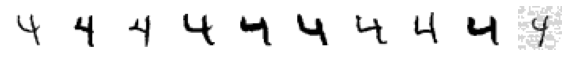

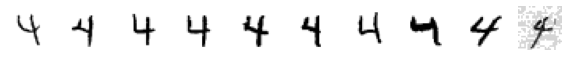

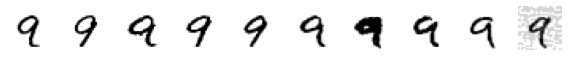

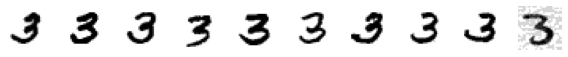

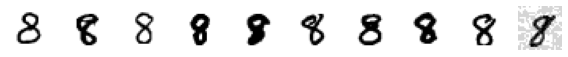

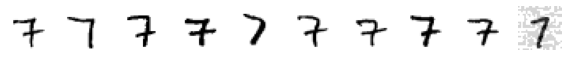

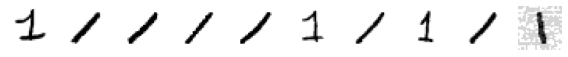

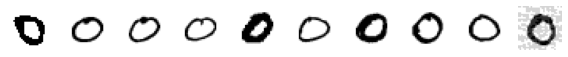

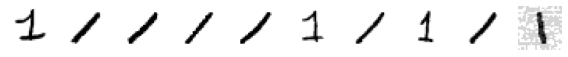

In [47]:
k = 10
for i in range(0,9):
  candidate_index = find_k_nn(universe_emb, search_emb[i], k)
  fig = plt.figure(figsize=(10, 0.8))

  gs = gridspec.GridSpec(1, len(candidate_index))
  for j in range(len(candidate_index)):
      ax = fig.add_subplot(gs[0, j])
      ax.imshow(X_train[candidate_index[j], :, :, :].reshape([28,28]),cmap="binary")
      ax.axis('off')
  plt.imshow(test_img[i].reshape(28,28),cmap="binary")
  plt.show()